## 1、XGBoost算法

XGBoost 是 eXtreme Gradient Boosting 的缩写称呼，它是一个非常强大的 Boosting 算法工具包，优秀的性能（效果与速度）让其在很长一段时间内霸屏数据科学比赛解决方案榜首，现在很多大厂的机器学习方案依旧会首选这个模型。

XGBoost 在**并行计算效率、缺失值处理、控制过拟合、预测泛化能力**上都变现非常优秀。本文我们给大家详细展开介绍 XGBoost，包含「算法原理」和「工程实现」两个方面。

## 2、算法原理可视化解读
关于 XGBoost 的原理，其作者陈天奇本人有一个非常详尽的Slides做了系统性的介绍，我们在这里借助于这个资料给大家做展开讲解。

### 2.1、监督学习核心要素
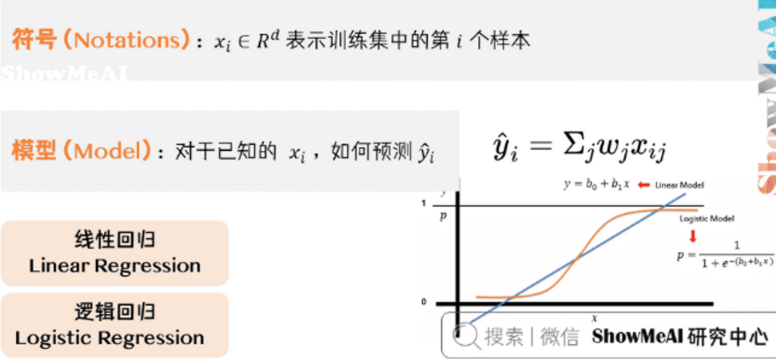

符号（Notations）：$ x_i \in R^d$表示训练集中的第i个样本。

模型（Model）：对于已知的$x_i$如何预测$\hat{y_i}$？

线性模型（Linear Model）:$\hat y = {\sum_{}}_j w_j x_ij$（包括线性回归和逻辑回归），预测值$\hat{y_i}$根据不同的任务有不同的解释：
- **线性回归**（Linear Regression）： $\hat{y_i}$表示预测回归的分数。
- **逻辑回归**（Logistic Regression）：$1/(1+e^{-\hat y_i})$ 预测了实例为正的概率。
- 其他：例如在排名任务中  $\hat{y_i}$可以是排名分数。

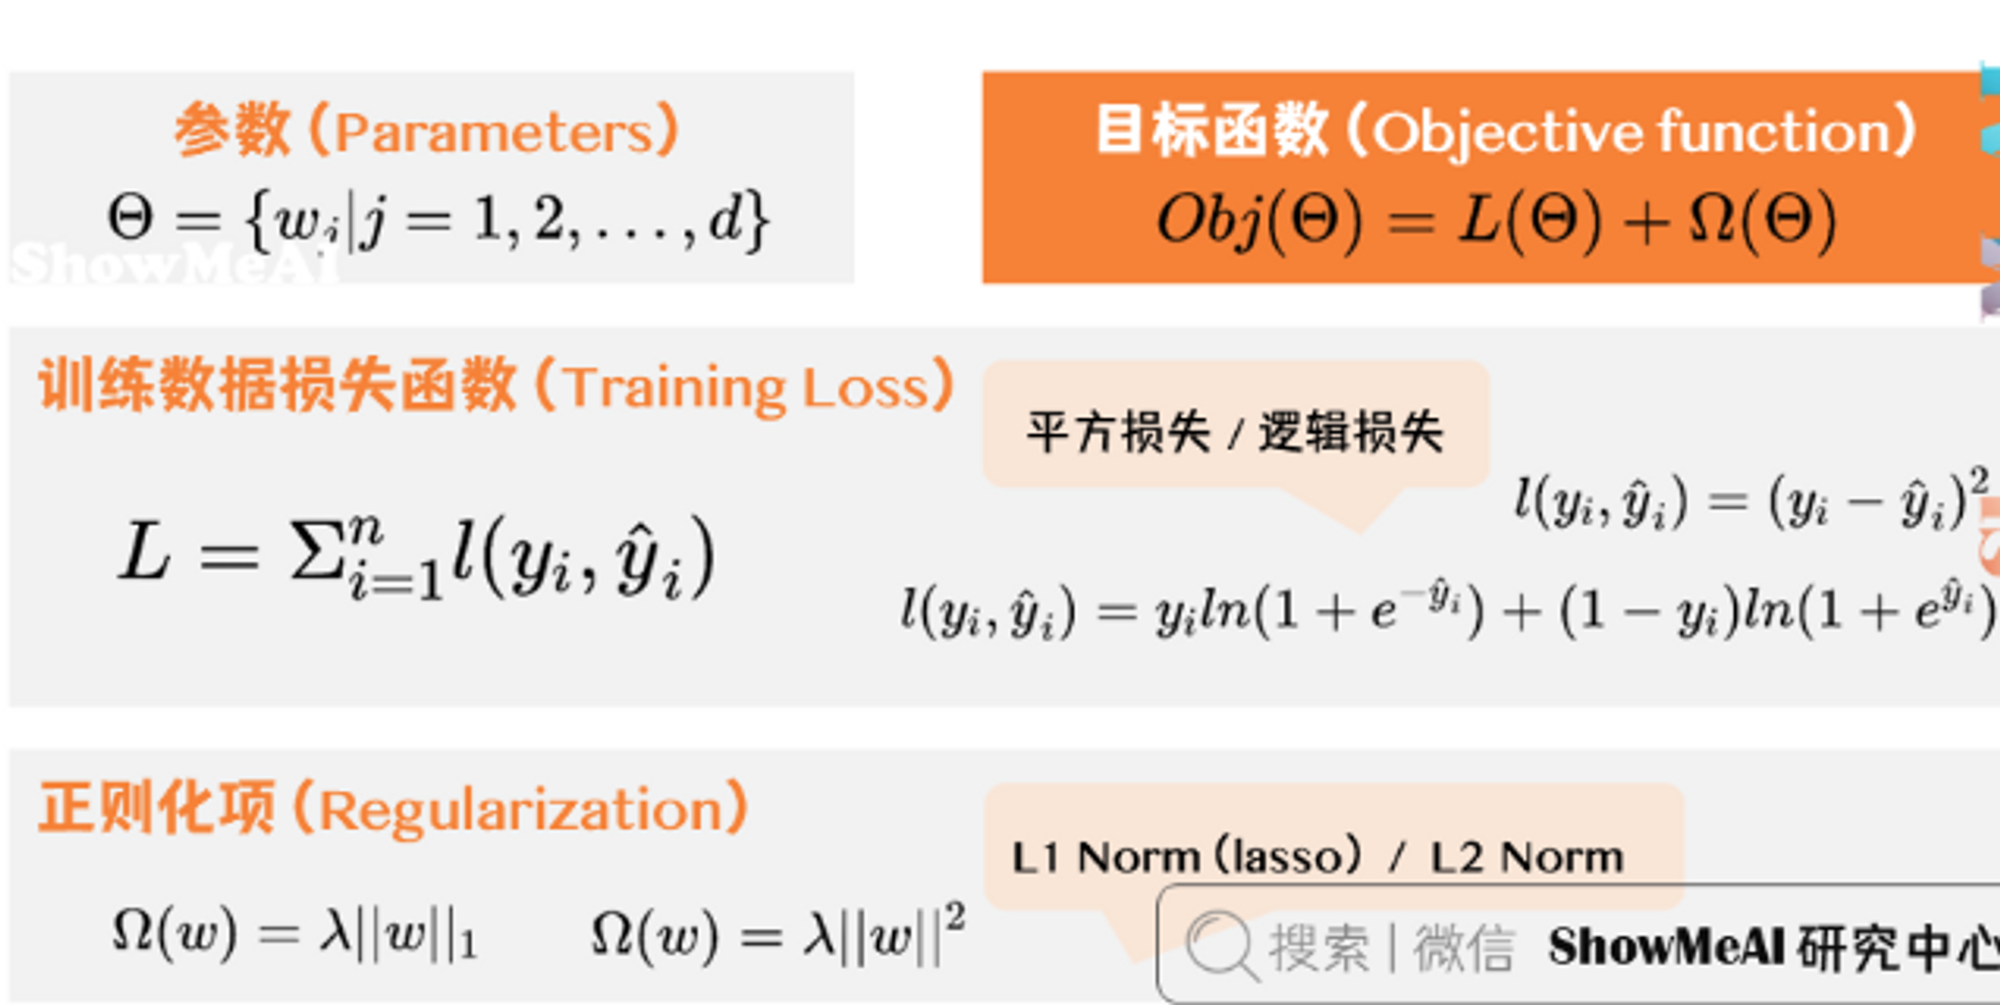

**参数**（Parameters）：需要从数据中学习的东西。

- 线性模型（Linear Model）：$\theta = \{w_j|j=1,2,….d \}$

**目标函数**（Objective function）:$Obj(\theta)=L(\theta)+\Omega(\theta)$

- $L(\theta)$代表训练损失函数（Training Loss），表示模型多好的拟合了训练数据。
- $\Omega(\theta)$:为正则化项（Regularization）衡量了模型的复杂程度。

**训练数据损失函数**（Training Loss）$L=\sum_{i=1}^n l(y_i,\hat y_i)$

- **平方损失**（Square Loss）：$l(y_i,\hat y_i)=(y_i - \hat y_i)^2$
- **逻辑损失**（Logistic Loss）：$l(y_i,\hat y_i)=y_i ln(1+e^-{\hat y_i})+(1-y)ln(1+e^{\hat y_i})$

**正则化项**（Regularization）：描述了模型的复杂程度。

- **L1 Norm（lasso）**：$\Omega(w)=\lambda \vert \vert(w)\vert \vert _1$
- **L2 Norm**：$\Omega(w)=\lambda \vert \vert(w)\vert \vert ^2$

### 2.2、监督学习进阶知识
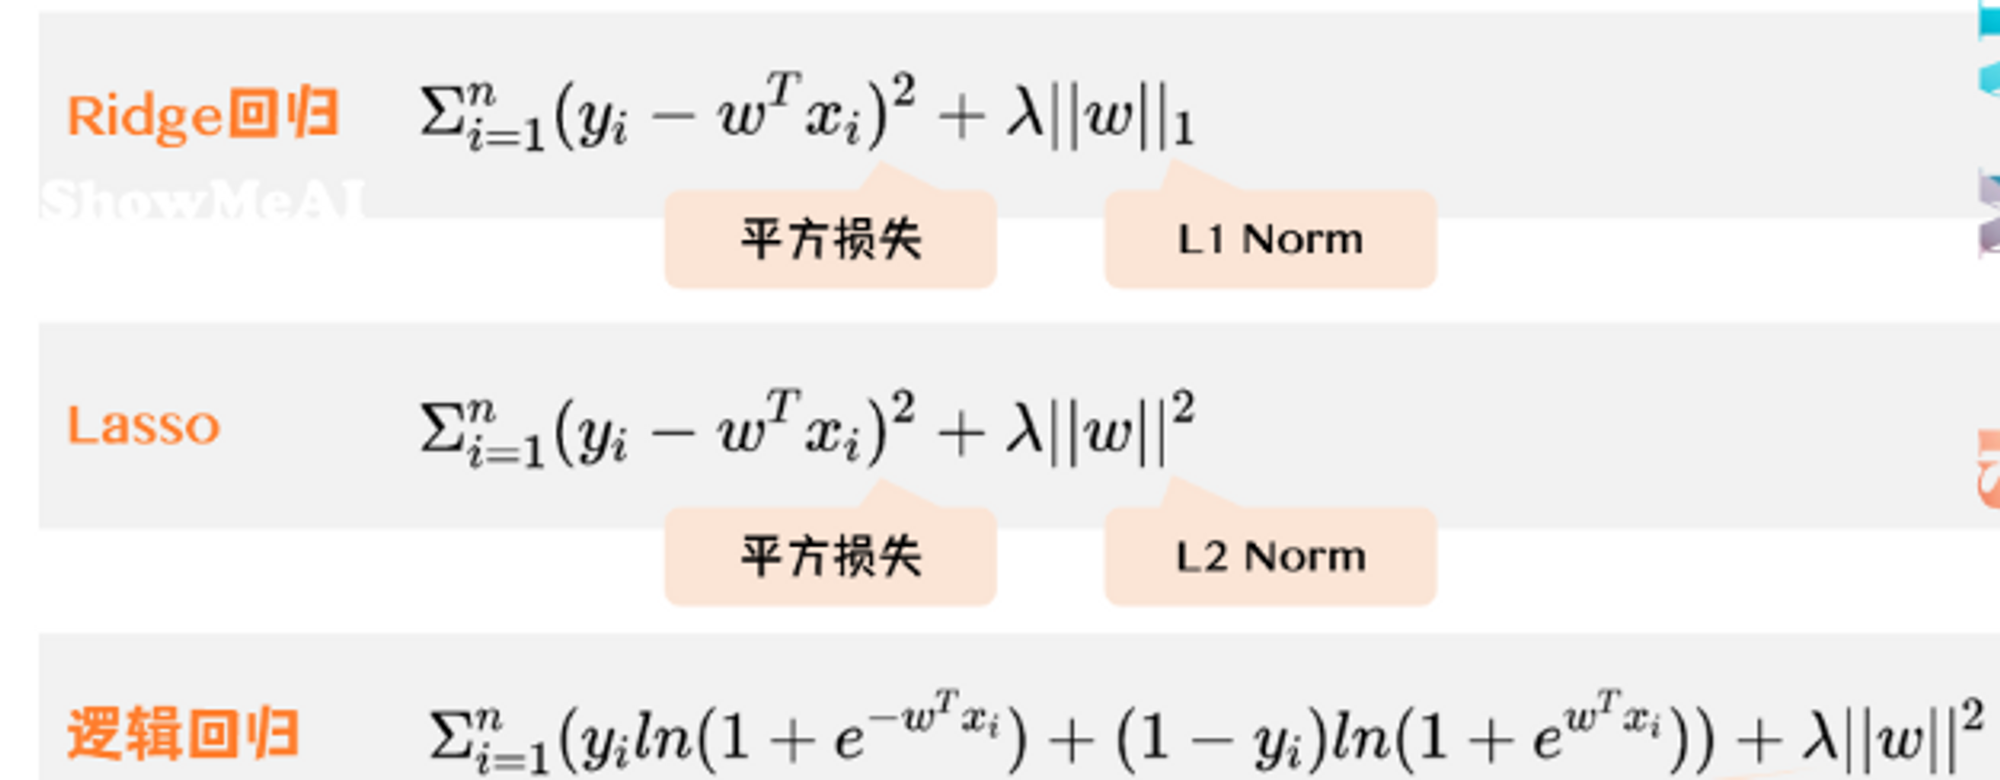

Ridge回归（L2正则化)：
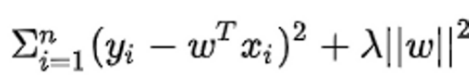
• Ridge 是线性模型（Linear Model），用的是平方损失（Square Loss），正则化项是 L2 Norm。

Lasso回归（L1正则化)：
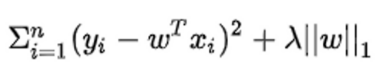
• Lasso是线性模型（Linear Model），用的是平方损失（Square Loss），正则化项是L1 Norm。

逻辑回归：
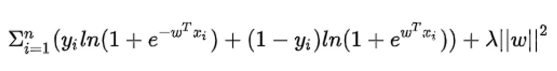
• 逻辑回归是线性模型（Linear Model），用的是逻辑损失（Logistic Loss），正则化项是 L2 Norm。

### 2.3、目标函数及偏差方差权衡
回顾一下目标函数$Obj(\theta)=L(\theta)+\Omega(\theta)$，为什么目标函数需要两部分组成呢？

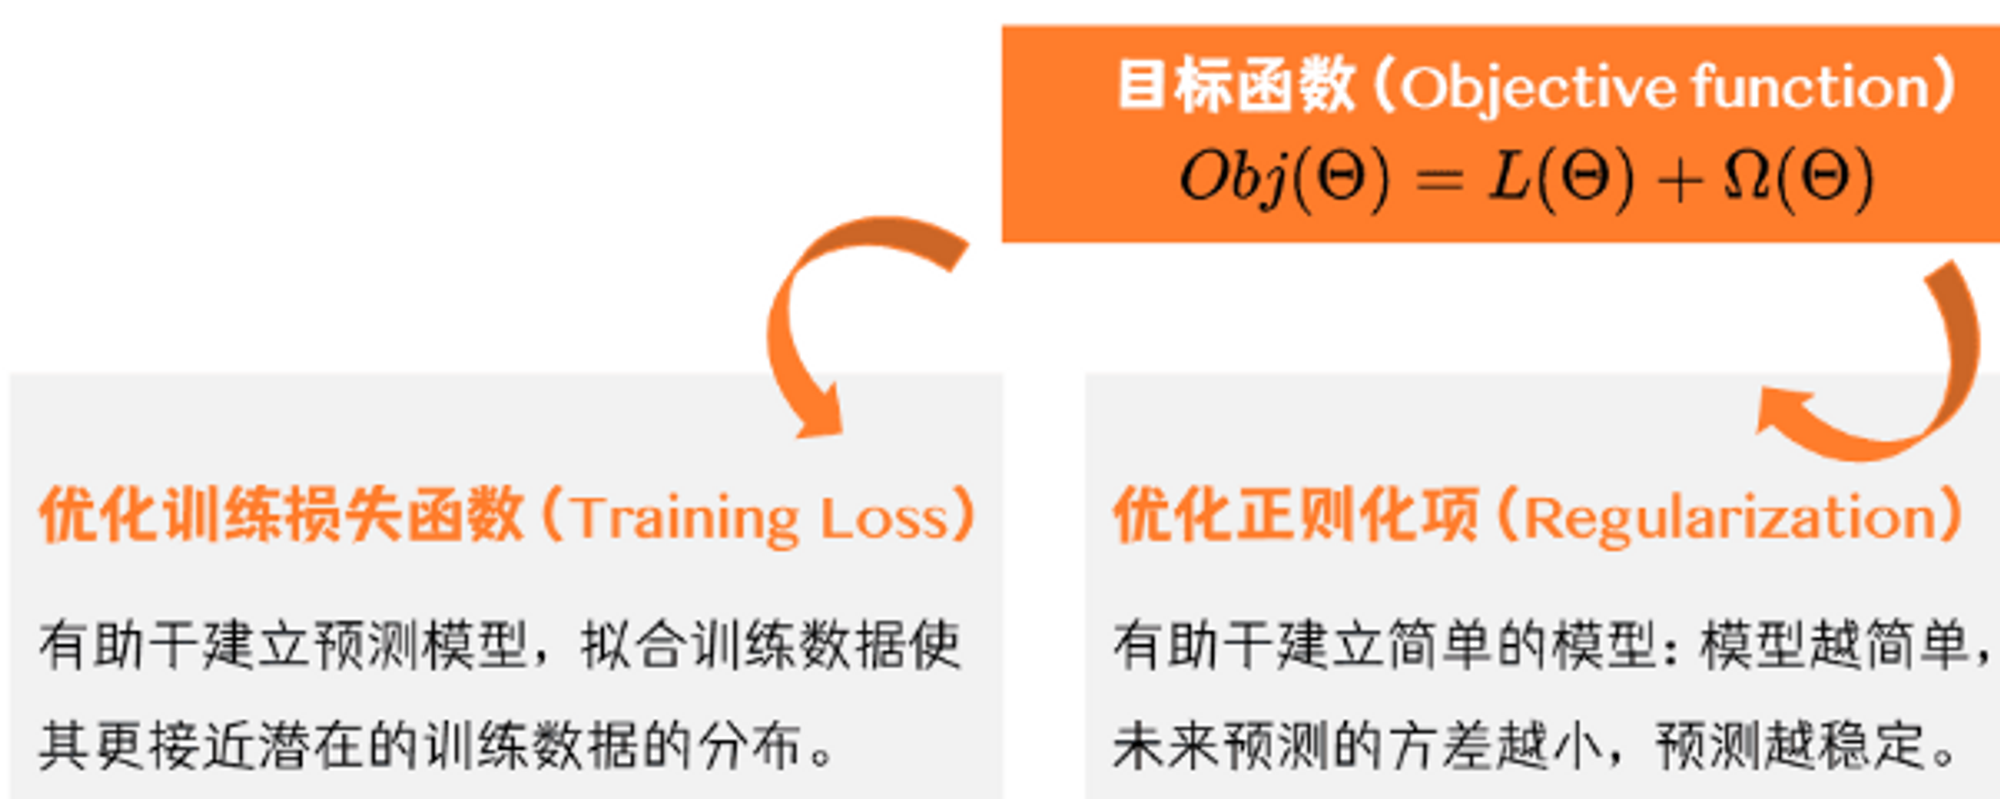
- **优化训练损失函数**（Training Loss）有助于建立预测模型，很好地拟合训练数据至少能让你更接近潜在的训练数据的分布。
- **优化正则化项**（Regularization）有助于建立简单的模型：模型越简单，未来预测的方差越小，预测越稳定。

## 3、XGBoost算法原理
案例讲解：
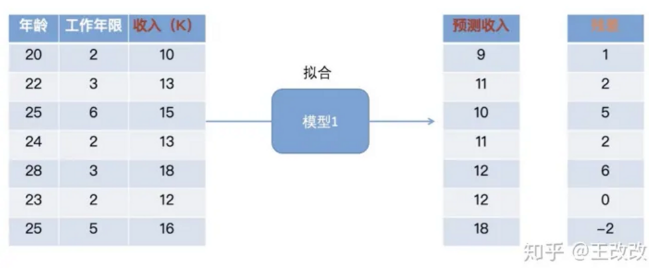
如上图所示，将左侧的数据输入到模型1中，会得到预测收入。预测收入和真实的收入之间的差值记做残差
。由于这个模型1有一定的能力，但是能力比较弱，遗留了一些问题。这个残差就能表征这个遗留的问题。

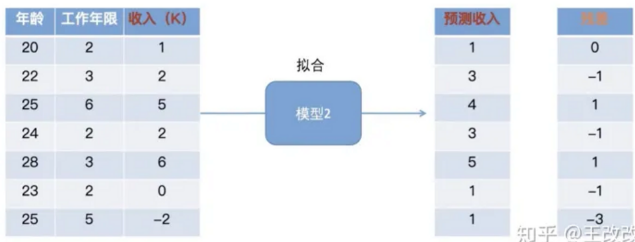
紧接着，再训练一个模型2去预测这些样本，只不过目标值改为刚刚得到的残差。上图所示，预测的结果不再是收入，而是模型1得到的残差。上图中的模型2还会得到残差，但是我们发现第一行样本的残差已经为零了。也就是说第一个样本，通过模型1和模型2能够预测对收入。但是除了第一行，其他的还是有残差的，这时候可以在这基础上训练一个模型3

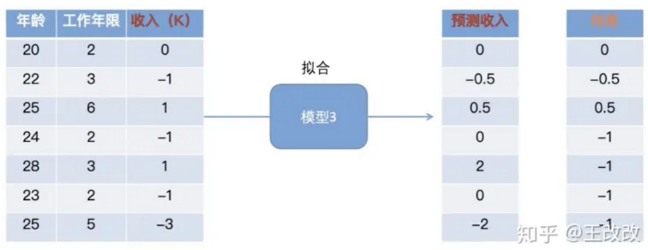
上图所示，在刚刚 模型2得到的残差（准确的说是模型1和模型2共同作用的结果）的基础上去拟合，得到模型3。这时候的残差可以理解为是前两个模型遗留下来的问题。该模型去预测模型2的残差，我们发现通过前三个模型的预测，得到的残差是上图中最新的残差这一列。

这时候最新的残差都是非常小了，如果能达到我们满意的标准，我们就可以停下。这样我们就得到了三个不同的模型。如下图所示，最终的预测就是三个模型预测的结果和。如下图：
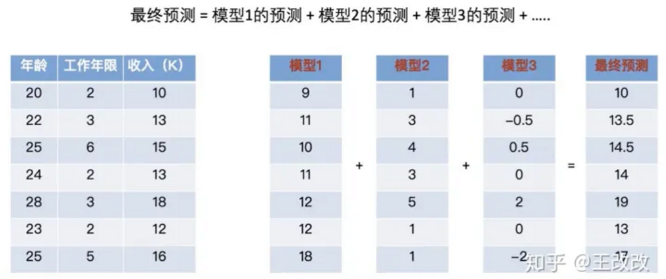

我们解决问题的步骤：

如何构造目标函数 -> 目标函数直接优化难，如何近似？ -> 如何把树的结构引入到目标函数？-> 仍然难优化，要不要使用贪心算法？

### 3.1 构建目标函数
首先举个例子，用多棵树来预测张三、李四的薪资。如下图所示，用年龄这个因素构建的树预测张三的值为12，用工作年限这个因素构建的树张三为2. 两个相加就是对张三薪资的预测：12+2=14。
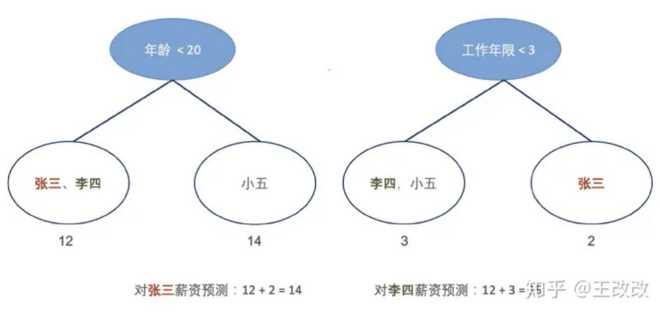

假设已经训练了$K$颗树，则对于第$i$个样本的最终预测值为：
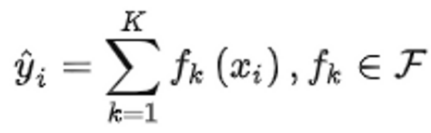
$x_i$是样本的特征，$f_k(x_i)$是用第$k$颗树$x_i$样本进行预测。将结果加在一起就得到了最终的预测值$\hat y_i$，而该样本的真实label是$y_i$。这样我们就能构建损失函数了。

构建的目标函数如下：
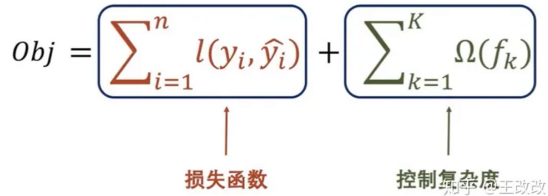

损失函数计算模型预测值和真实值的 loss，其中$l$是损失函数，可以是 MSE、Cross Entropy 等等。

第二项是正则项，来控制模型的复杂度，防止过拟合。这个正则项可以类比 L2 正则。

### 3.2叠加式的训练
如下图所示，将样本$x_i$放入第一棵树后，会得到一个预测值$f_1(x_i)$，将该样本放入到第二颗树中后会得到$f_2(x_i)$。依次类推。
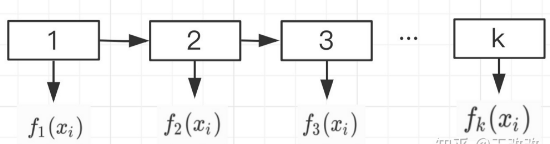
假设给定样本$x_i$且$\hat y_i ^{0} = 0$：

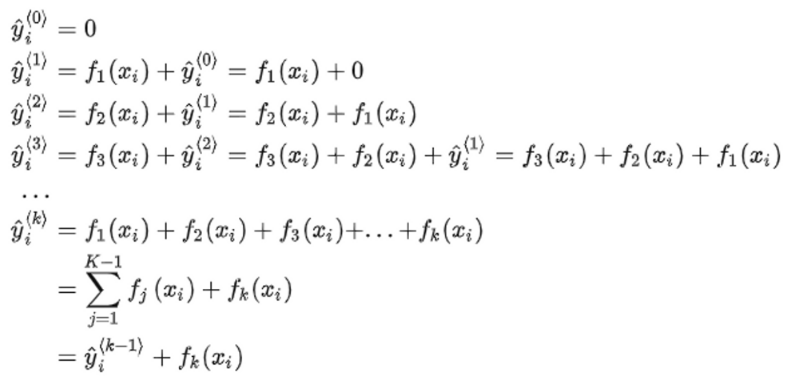
其中$\hat y_i ^{m}$ 是到第 m 课树为止累加的一个预测结果。通过推断，我们可以知道：

$$$ \hat y_i^{k} = \hat y_i^{k-1} + f_k({x_i}) $,到第 $k$颗树时累加的结果是前 ${k-1}$颗树累计的结果和第k

颗树输出的结果总和。有了这个推论，我们再看目标函数：

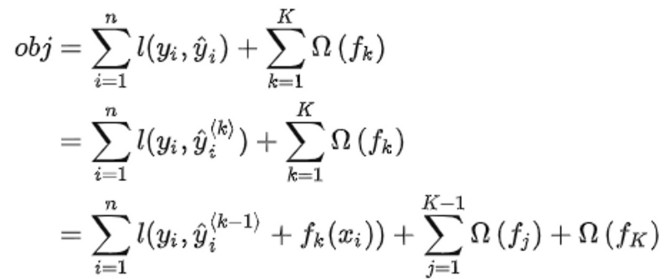
因为最终的预测结果是所有模型（树）累加的结果，所以可以把$\hat y_i$ 写成$\hat y_i ^{k}$（到第 k 课树为止累加的一个预测结果）当训练第 k 颗树时，最小化下面的损失函数：
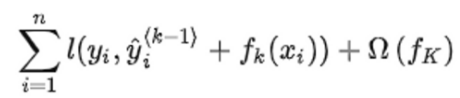

相比之下，该式子去掉了$\sum_ {i-1}^{K-1}{\Omega(f_j)}$这一项，因为训练第K颗树时，该项为常数项，因为在训练第K颗树的时候，前K−1颗树的复杂度是已知的，不需要关注前面这些树了。到此为止，我们得出了目标函数：
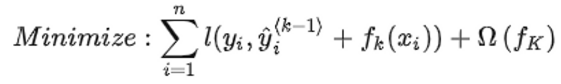

### 3.3用泰勒级数近似目标函数
这个目标函数是非常复杂的，我们可以用泰勒级数来近似这个目标函数。

目标函数：
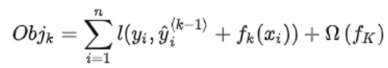
根据泰勒展开式：


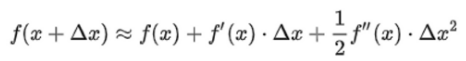
紧接着, 我们把$\hat y_i^{k-1}$视作$x$, 把$f_k(x_i)$ 视作 Δx

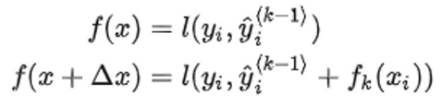

而根据泰勒展开式可以知道（仔细看就能看懂）：
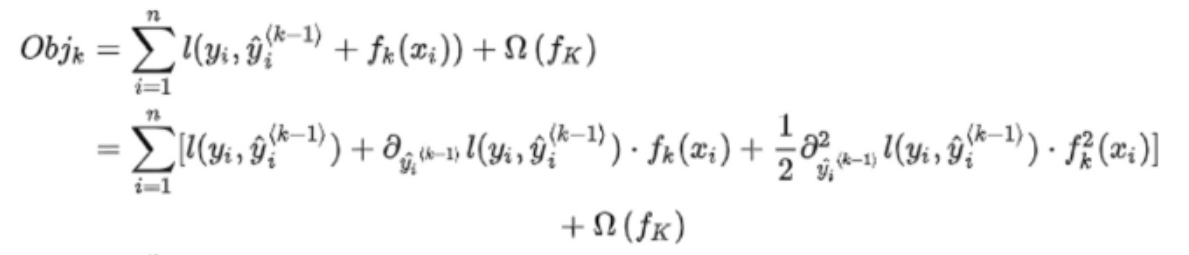

当前目标函数是训练第K颗树时的函数，其中$l(y_i,\hat y_i^{(k-1)})$项是真实值与到第K-1课树为止累加的预测结果的损失，可以看作是已知的，不参与优化的过程。并且$∂_{\hat y_i^{(k-1)}}l(y_i,y_i^{(k-1)})$   和$∂_{\hat y_i^{(k-1)}}^2l(y_i,y_i^{(k-1)})$  

也可以看成已知的。我们假设上式中$∂_{\hat y_i^{(k-1)}}l(y_i,y_i^{(k-1)})=g_i$，$∂_{\hat y_i^{(k-1)}}^2l(y_i,y_i^{(k-1)})=h_i$故：

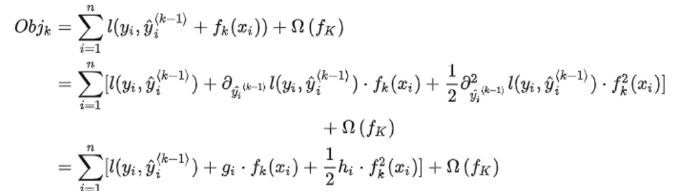

可以将目标函数简化为如下的形式：
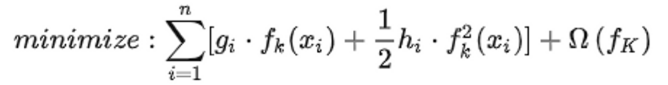

当训练第k颗树的时候，$\{h_i,g_i\}$是已知的，${h_i,g_i}$可以看作是训练前K-1棵树时的残差。由于我们要优化这个目标函数，接下来需要把$f_k{(x_i)}$,${\Omega(f_k)}$参数化

### 3.4如何用参数表示一颗树
叶子结点的值用$w$表示，我们假设 15 这个叶节点用$w_1$表示，12 这个叶子结点用$w_2$表示，20 这个叶子结点用$w_3$

表示。$W=(w_1,w_2,w_3)=(15,12,20)$这里的$W$就是一个参数。

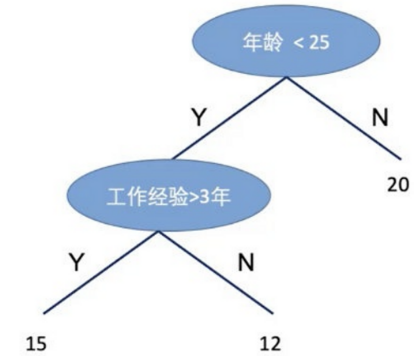
接下来的目标是把$f_k{(x_i)}$,${\Omega(f_k)}$参数化。

$f_k{(x_i)}$是什么呢 ？简单来说:$f_k{(x_i)}$就是第$k$课树对样本$x_i$的预测结果。更具体的，就是把第$x_i$个样本规划到第几个

叶子结点上了。

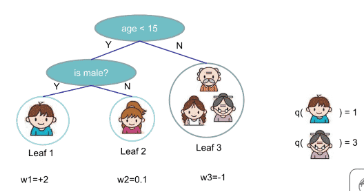


这里定义一个函数$q(x)$样本$x$的位置。这里假设第一个叶节点上（即 15 的地方）有样本[1, 3]落在这里 ,第二个节点有样本[4]落在这个地方，样本[2,5]落在了第三个叶子结点处这里 ：
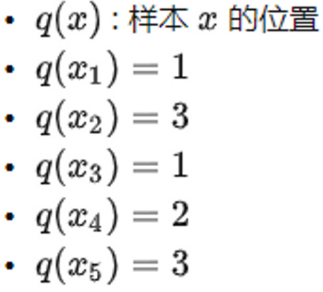

用函数$q$表示了样本落在了那个位置后，就能用参数表示$f_k{(x_i)}$了。 样本$x_i$落在了第$q(x_i)$个叶节点上。那么

$f_k{(x_i)}$的预测值就可以用$W_q(x_i)$表示，这样就把$f_k{(x_i)}$进行了参数化。$W$是一个参数，下角标$q(x_i)$表示落在哪个叶子结点上。但是这里下标还是一个函数，需要定义一下：

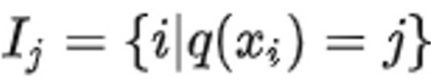
即表示哪些样本$x_i$落在第$j$个叶子结点上。举个例子：$I_1=\{1,3\}$表示样本 1，3 落在了第一个节点上。这样进行表示的目的是根据叶节点的位置把样本进行重新的组织。

### 3.5、定义树的复杂度
刚刚把$f_k{(x_i)}$进行了参数化，接下来的目标是把${\Omega(f_k)}$参数化。

一颗树的复杂度可以通过叶节点个数和 leaf value 。如下式子，其中$T$为叶节点的个数，第二项表示 leaf value：
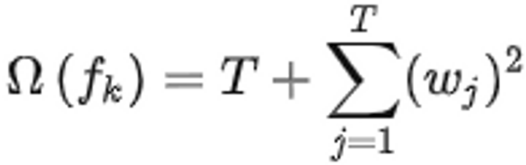

### 3.6、新的目标函数
经过上面的一步步的简化，我们把最初的目标函数：
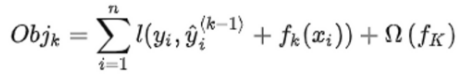
简化为了：
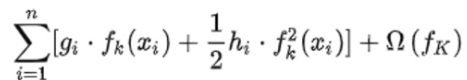

紧接着，我们根据刚刚定义的参数：$W$叶节点的值，$q(x_i)$样本$x_i$落在哪个叶节点上。$I_j$第$j$个节点有哪些样本。

$f_k{(x_i)}$的预测值就可以用$W_{q(x_i)}$表示，可得到：
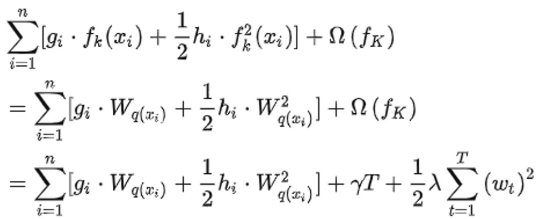

紧接着，看下图，假设第一个叶节点上（即 15 的地方）有样本[1, 3]落在这里 ,第二个节点有样本[2]落在这个地方，样本[4,5]落在了第三个叶子结点处这里 ：
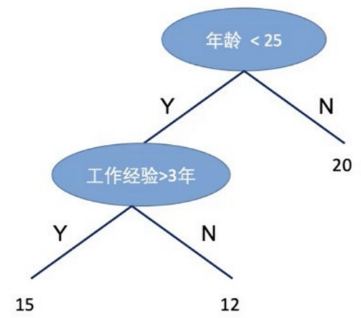
所以：

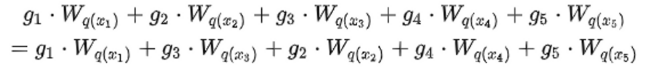
而其中的$g_4 \bullet W_{q(x_4)} + g_5 \bullet W_{q(x_5)}$又可以表示为（因为样本[4,5]落在了第三个叶子结点处）：
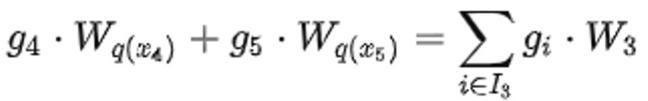

因为$I_j=\{i|q(x_i)=j \}$。所以我们可以进一步构造新的目标函数：
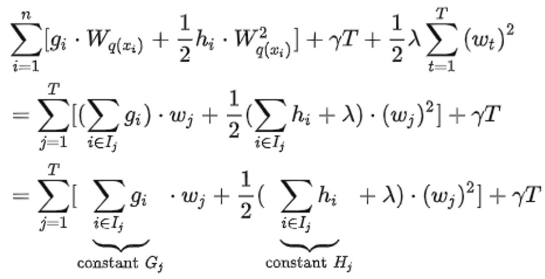
这个式子中，$\sum_{i \in I_j}g_i$和$\frac 12(\sum_{i \in I_j}h_i + \lambda)$是已知的，分别记做$G_j$和$H_j$。参数是$w_j$。所以是一个关于$w_j$

二次函数求最优解问题。

知识回顾，典型的二次函数：
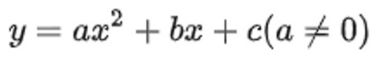
最小点的值为：
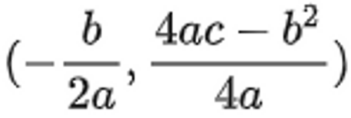
所以，所以当树的结构固定，也就是说$q(x)$固定的话，在中括号中的最佳$w_j^*$为：

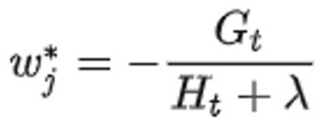
将$w_j^*$带入到至上述的目标函数中可得，当前树结构下的最佳的目标函数值：
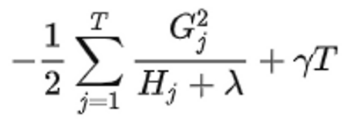
当我们的知道了训练第k棵树时最小的目标函数值$obj_k^*$后，随意给出一颗树（已知树结构），就能算出该棵树下最小的目标函数值。但是可能会有很多颗树，所以我们需要找到目标函数值最小的那颗树。那么如何去寻找这棵树呢？把可能所有的树罗列出来是代价很大的，这时候就需要贪心的方法。

### 3.7、如何寻找树的形状？(level-wise)
我们寻找最小的$obj_k^*$，原来我们有一颗树，我们是能够计算出这棵树最小的目标函数值的。紧接着
**根据特征进行分割落在叶节点的样本，树结构发生改变，这时候新的树的目标函数值也是能够算出来的**。所以使用贪心
的方式，选择新的树目标函数值较小的那颗树。

比如下面这个例子，我们有样本[1、2、3、4、5、6、7、8]，第一颗树把这些样本分为了两部分，左侧的叶子结点是

[7,8]，右侧节点是[1,2,3,4,5,6]。

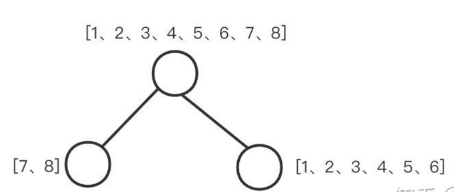
此时我们知道了树的结构，可以根据如下的公式计算出此时树的最小目标函数值：
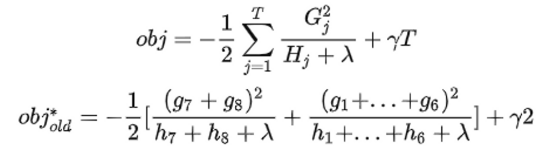
紧接着，我们根据新的特征对叶子结点再次进行了分割，得到了如下的树的形状：

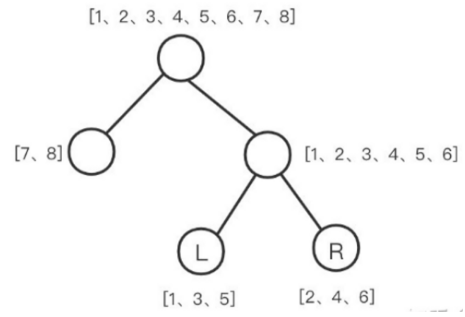
此时，得到了新的$Obj_{new}^*$:
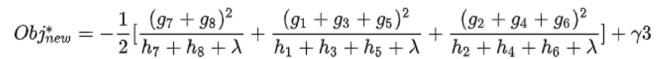
紧接着计算两颗树最小目标函数值的差：
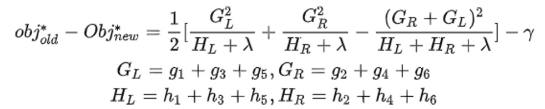
当$Obj_{old}^* - Obj_{new}^*$最大化的时候，(可以理解为信息增益值最大），便是$Obj_{new}^*$最小的时候。这样我们通过贪心的方式不断构造这棵树，不断扩充这棵树

## 4.XGBoost工程优化
### 4.1、并行列块设计
XGBoost 将每一列特征提前进行排序，以块（Block）的形式储存在缓存中，并以索引将特征值和梯度统计量对应起来，每次节点分裂时会重复调用排好序的块。而且不同特征会分布在独立的块中，因此可以进行分布式或多线程的计算。
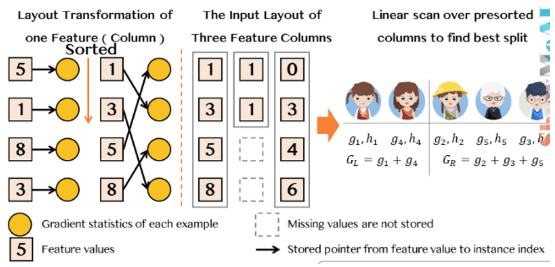

### 4.2、缓存访问优化
特征值排序后通过索引来取梯度$g_i$,$h_i$会导致访问的内存空间不一致，进而降低缓存的命中率，影响算法效率。为解决这个问题，XGBoost为每个线程分配一个单独的连续缓存区，用来存放梯度信息。

### 4.3、核外块计算
数据量非常大的情形下，无法同时全部载入内存。XGBoost 将数据分为多个 blocks 储存在硬盘中，使用一个独立的线程专门从磁盘中读取数据到内存中，实现计算和读取数据的同时进行。为了进一步提高磁盘读取数据性能，XGBoost 还使用了两种方法：

- ① 压缩 block，用解压缩的开销换取磁盘读取的开销。
- ② 将 block 分散储存在多个磁盘中，提高磁盘吞吐量。

## 5.XGBoost vs GBDT
GBDT和这里的 XGBoost 做一个对比总结：
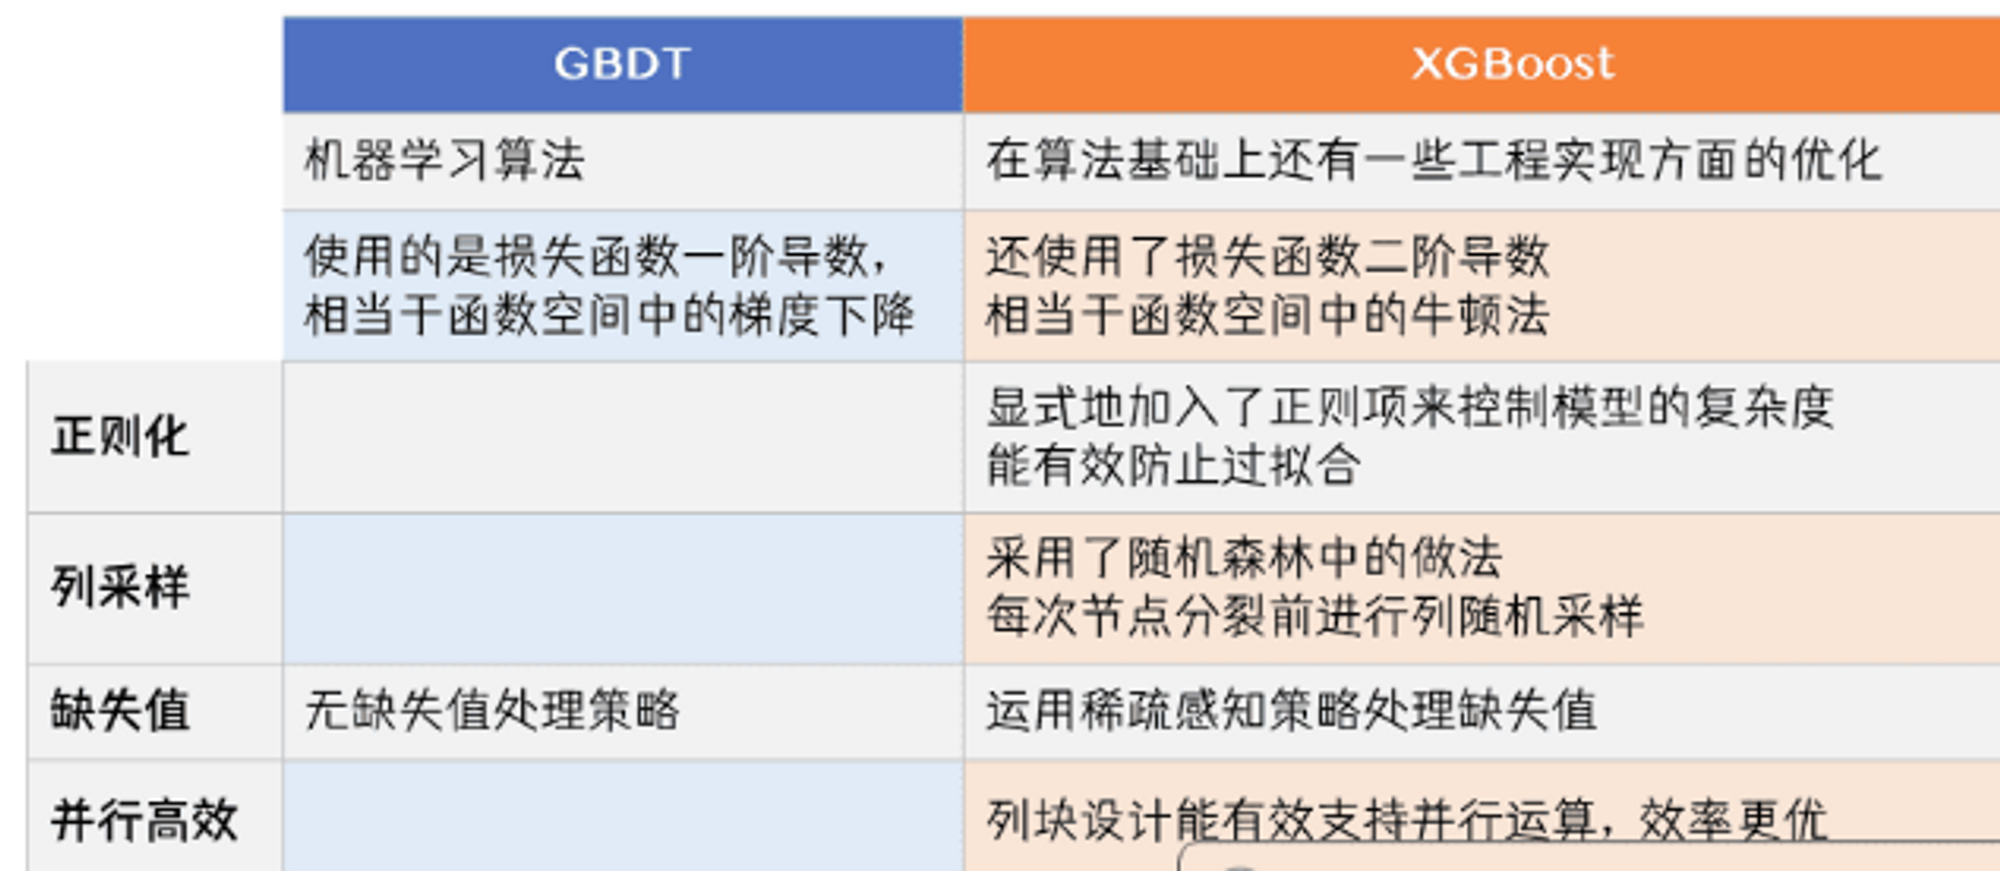

- GBDT 是机器学习算法，XGBoost 在算法基础上还有一些工程实现方面的优化。
- GBDT 使用的是损失函数一阶导数，相当于函数空间中的梯度下降；XGBoost 还使用了损失函数二阶导数，相当于函数空间中的牛顿法。
- **正则化**：XGBoost 显式地加入了正则项来控制模型的复杂度，能有效防止过拟合。
- **列采样**：XGBoost 采用了随机森林中的做法，每次节点分裂前进行列随机采样。
- **缺失值**：XGBoost 运用稀疏感知策略处理缺失值，GBDT无缺失值处理策略。
- **并行高效**：XGBoost 的列块设计能有效支持并行运算，效率更优。

## 6、代码演示-XGBoost
- sklearn


[08:52:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



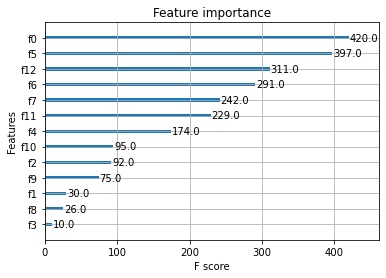

In [14]:
##特征分析

import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
 
# 导入数据集
boston = load_boston()
X ,y = boston.data,boston.target
 
# Xgboost训练过程
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
 
model = xgb.XGBRegressor(max_depth=5,learning_rate=0.1,n_estimators=160,silent=True,objective='reg:gamma')
model.fit(X_train,y_train)
 
# 对测试集进行预测
ans = model.predict(X_test)
 
# 显示重要特征
plot_importance(model)
plt.show()

[08:52:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Accuracy: 100.00 % 


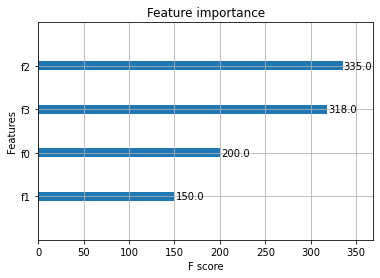

In [15]:
from sklearn.datasets import load_iris
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# read in the iris data
iris = load_iris()

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 训练模型
model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='multi:softmax')
model.fit(X_train, y_train)

# 对测试集进行预测
ans = model.predict(X_test)

# 计算准确率
cnt1 = 0
cnt2 = 0
for i in range(len(y_test)):
    if ans[i] == y_test[i]:
        cnt1 += 1
    else:
        cnt2 += 1

print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))

# 显示重要特征
plot_importance(model)
plt.show()